# Represetation Learning and Mutual Information Maximization in Variational Autoencoder
It might come as surprising at first that variational autoencoders (VAE) do not naturally learn good representations, contrary to what many seen in class of the stunning VAE MNIST latent space example. In fact, VAEs often ignores the latent variable when the decoder is highly expressive. 

One way of framing good representations is that the representations are disentangled, although what exactly disentanglment means is still under debate. It is now widely accepted that good representations are a property of the joint observed-latent distribution, which intuitively is weakly connected to minimizing the marginal distribution (see this [blog](https://www.inference.vc/maximum-likelihood-for-representation-learning-2/)). A relatively straightforward way to measure the quality of representations and learn better representation is to encourage higher mutual information between the observed and the latent. As discussed in the blog and this [paper](https://arxiv.org/abs/1711.00464), different models achieving the same marginal likelihood might score very differently on mutual information. 

Our goal in this notebook is to study how adding a mutual information bonus to the VAE objective (i.e., the evidence lower bound; ELBO) may change and perhaps improve the type of representation we learn. We will replicate an small experiment in this [paper](https://openreview.net/forum?id=HkbmWqxCZ), where we split a standard Normal distribution into multiple components. Let's discuss it below.

This is a (modified) copy. The original notebook is found [here](https://www.kaggle.com/code/runway/mutual-information-representation-learning/notebook)

## Splitting the Normal
We will create synthetic data samples from a standard Normal: $q(x) = \mathcal{N}(x|0, 1)$. Our goal is to train a pair of decoder $p_{\theta}(x|z)$ and encoder $q_{\theta}(z|x)$ with a fixed prior $p(x) = \mathcal{N}(x|0, 1)$ to model the data samples. Both the decoder and encoder distributions are modeled as univariate Normals with mean and log variance output by neural networks. So far this is the standard VAE setting. There exists a trivial optimum of the VAE objective: $p_{\theta}(x|z) = q_{\theta}(z|x) = \mathcal{N}(0, 1)$, which indeed models the data distribution perfectly but ignores the latent variable. 

The idea here is to optimize the VAE objective while also encourage high mutual information between the observed and the latent under the model. Since mutual information is generally intractable, we will maximize a lower bound:
\begin{align}
\begin{split}
\mathcal{I}(x, z) &= \mathbb{E}_{p(x, z)}\left[\log\frac{p(x, z)}{p(x)p(z)}\right] \\
&= \mathbb{E}_{p(x, z)}\left[\log p(z|x)\right] - \mathbb{E}_{p(x, z)}[p(z)] \\
&= \mathbb{E}_{p(x, z)}\left[\log\frac{p(z|x)q_{\theta}(z|x)}{q_{\theta}(z|x)}\right] + \mathcal{H}[p(z)]\\
&= \mathbb{E}_{p(x, z)}\left[\log q_{\theta}(z|x)\right] + \mathcal{H}[p(z)] + \mathbb{E}_{p(z)}\left[D_{KL}[p(z|x) || q_{\theta}(z|x)]\right]\\
&\geq \mathbb{E}_{p(x, z)}\left[\log q_{\theta}(z|x)\right] + \mathcal{H}[p(z)]
\end{split}
\end{align}
It is important to note that the first expectation is evaluated under the *model distribution*: $p(x|z) = p_{\theta}(x|z)p(z)$ rather than samples from the dataset. 

We will add mutual information to the VAE objective using the following penalty:
\begin{align}
\min\mathcal{L} = C\left|\mathbb{E}_{p(x, z)}\left[\log q_{\theta}(z|x)\right] + \mathcal{H}[p(z)] - M\right|
\end{align}
where $M$ is the target mutual information value we want to achieve, $C$ is the strength of the penalty in the form of absolute deviation error from the target mutual information.

When we are done, we will look at the decoding distributions corresponding to different values of the latents. We expect the decoding distributions to be less overlapped at mutual information increases.

In [11]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.distributions as torch_dist

In [282]:
seed = 0

# set plotting style
strip_size = 12
label_size = 14
mpl.rcParams["axes.labelsize"] = label_size
mpl.rcParams["xtick.labelsize"] = strip_size
mpl.rcParams["ytick.labelsize"] = strip_size
mpl.rcParams["legend.title_fontsize"] = strip_size
mpl.rcParams["axes.titlesize"] = label_size
mpl.rcParams["figure.titlesize"] = label_size

In [283]:
df = pd.read_csv('/home/markus/Downloads/DM_LOCATION_10336477_29_20240919104841.csv', parse_dates=['TIMESTAMP'])

/tmp/ipykernel_1659024/1964782156.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/home/markus/Downloads/DM_LOCATION_10336477_29_20240919104841.csv', parse_dates=['TIMESTAMP'])


<Axes: xlabel='TIMESTAMP'>

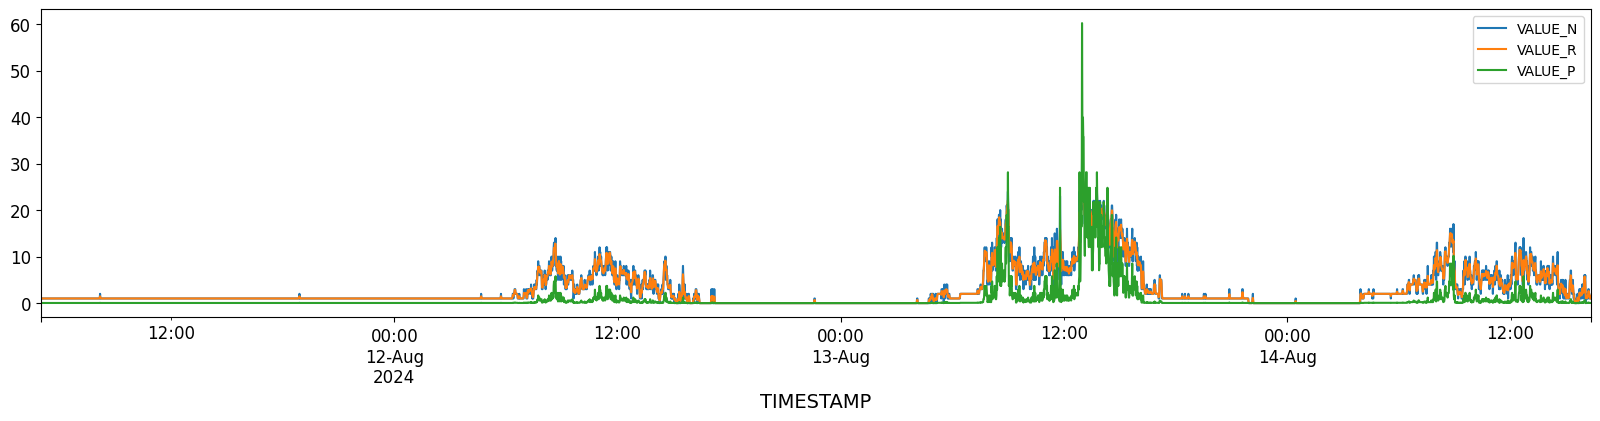

In [284]:
df = df.sort_values(by='TIMESTAMP')
#df['VALUE_R'] = np.flip(df['VALUE_N'].values)
df['VALUE_R'] = np.convolve(df['VALUE_N'].values,[1,3,7,3,1], mode='same') / 15
poly = np.polynomial.polynomial.Polynomial([0.01,0.02,0.0,0.002])
df['VALUE_P'] = poly(df['VALUE_N'].values)

df[0:5000].plot(x='TIMESTAMP', figsize=(20,4))

In [311]:
from sklearn import preprocessing

df_scale = pd.DataFrame(preprocessing.StandardScaler().
                        fit_transform(df[['VALUE_N','VALUE_R','VALUE_P']].values), columns=['VALUE_N', 'VALUE_R', 'VALUE_P'])

In [285]:
'''
from sklearn.decomposition import PCA, FactorAnalysis

pca = PCA(svd_solver="full")

pca = PCA(svd_solver="full", n_components="mle")
pca.fit(df[['VALUE_N','VALUE_R','VALUE_P']].values)
n_components_pca_mle = pca.n_components_

pca_trans = pca.transform(df[['VALUE_N','VALUE_R','VALUE_P']].values)
df_pca = pd.DataFrame(pca_trans, columns=['VALUE_N', 'VALUE_P'])
'''

'\nfrom sklearn.decomposition import PCA, FactorAnalysis\n\npca = PCA(svd_solver="full")\n\npca = PCA(svd_solver="full", n_components="mle")\npca.fit(df[[\'VALUE_N\',\'VALUE_R\',\'VALUE_P\']].values)\nn_components_pca_mle = pca.n_components_\n\npca_trans = pca.transform(df[[\'VALUE_N\',\'VALUE_R\',\'VALUE_P\']].values)\ndf_pca = pd.DataFrame(pca_trans, columns=[\'VALUE_N\', \'VALUE_P\'])\n'

In [312]:
# create dataset
torch.manual_seed(seed)

num_samples = 5000

#true_dist = torch_dist.Normal(torch.zeros(1), 

x = torch.Tensor(df_scale[0:5000][['VALUE_N','VALUE_R','VALUE_P']].values)
#x = torch.Tensor(df_pca[0:5000].values)

In [313]:
xn = x.numpy().T

(3, 5000)
(5000,)


<Axes: xlabel='VALUE_N', ylabel='VALUE_P'>

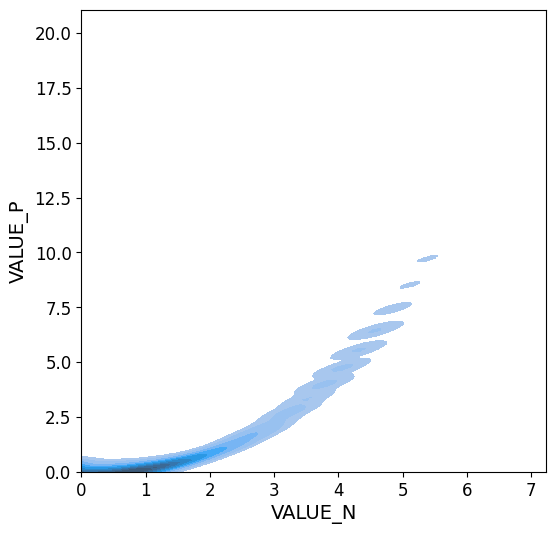

In [314]:
from scipy import stats
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import seaborn as sns


#from mayavi import mlab

kde = stats.gaussian_kde(xn)
print(xn.shape)
density = kde(xn)
print(density.shape)

#fig, ax = plt.subplots(1,1, figsize(6.6))
#ax.scatter_plot(xn[:,0], xn[:,1], c=density
df_help = pd.DataFrame(np.vstack([xn[0,:], xn[1,:], density]).T, columns=['x','y','density'])
df_short = df_scale[0:5000].copy()
#df_short = df_pca[0:5000].copy()

                       
df_short['density'] = density
fig, ax = plt.subplots(1,1, figsize=(6,6))
#df_short.plot(x='VALUE_N',y='VALUE_R',c=density,kind='scatter', ax=ax)


sns.kdeplot(data=df_short, x='VALUE_N', y='VALUE_P', cut=0, clip=(0,25), fill=True,ax=ax)



In [290]:
class MLP(nn.Module):
    """ MLP network """
    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden):
        super().__init__()
        layers = []
        last_dim = input_dim
        for i in range(num_hidden + 1):
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            last_dim = hidden_dim
        self.layers = nn.ModuleList(layers)

        self.head = nn.Linear(last_dim, output_dim)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        out = self.head(x)
        return out

In [294]:
class VAE(nn.Module):
    def __init__(self, x_dim, z_dim, hidden_dim, num_hidden, m, c):
        super().__init__()
        self.z_dim = z_dim
        self.m = m # mutual information target
        self.c = c # mutual information penalty

        self.encoder = MLP(x_dim, z_dim * 2, hidden_dim, num_hidden)
        self.decoder = MLP(z_dim, x_dim * 2, hidden_dim, num_hidden)

    def encode(self, x):
        z_mu, z_lv = torch.chunk(self.encoder(x), 2, dim=-1)
        z_dist = torch_dist.Normal(z_mu, z_lv.clip(-10, 5).exp())
        return z_dist

    def decode(self, z):
        x_mu, x_lv = torch.chunk(self.decoder(z), 2, dim=-1)
        x_dist = torch_dist.Normal(x_mu, x_lv.clip(-10, 5).exp())
        return x_dist
    
    def compute_mi(self, x):
        """ Compute mutual information """
        batch_size = x.shape[0]
        prior_dist = torch_dist.Normal(
            torch.zeros(self.z_dim), torch.ones(self.z_dim)
        )
        z = prior_dist.sample((batch_size,))
        x = self.decode(z).rsample()
        z_dist = self.encode(x)
        logp_z = z_dist.log_prob(z)
        mi = logp_z.mean() + prior_dist.entropy().sum(-1)
        return mi

    def compute_loss(self, x):
        # compute elbo loss
        prior_dist = torch_dist.Normal(
            torch.zeros(1, self.z_dim), torch.ones(1, self.z_dim)
        )
        z_dist = self.encode(x)
        z = z_dist.rsample()
        x_dist = self.decode(z)

        logp_x = x_dist.log_prob(x).sum(-1)
        kl = torch_dist.kl.kl_divergence(z_dist, prior_dist).sum(-1)
        elbo_loss = -torch.mean(logp_x - kl)
        
        # compute mutual information constraint loss
        mi = self.compute_mi(x)
        #mi_loss = self.c * torch.abs(mi - self.m)
        mi_loss = self.c * torch.nn.functional.relu(self.m - mi)

        loss = elbo_loss + mi_loss
        
        stats = {
            "loss": loss.data.item(),
            "elbo": -elbo_loss.data.item(),
            "mi": mi.data.item()
        }
        return loss, stats

In [295]:
def train(model, data, lr, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    history = []
    bar = tqdm(range(epochs))
    for e in bar:
        loss, stats = model.compute_loss(data)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        bar.set_description(f"e: {e+1}, loss: {loss.data.item():.4f}")

        history.append(stats)
    
    df_history = pd.DataFrame(history)
    return model, df_history

def plot_scaled_normals(model, ax):
    """ Plot p(x|z)p(z) """
    z_test = torch.tensor([-2.1, -1.3, -0.4, 0.4, 1.3, 2.1]).view(-1, 1)
    with torch.no_grad():
        x_dist = model.decode(z_test)
    
    prior_dist = torch_dist.Normal(
        torch.zeros(1, model.z_dim), torch.ones(1, model.z_dim)
    )
    grid = torch.linspace(-4, 4, 1000)

    pdf = torch.exp(x_dist.log_prob(grid) + prior_dist.log_prob(z_test))
    
    ax.plot(grid.view(1, -1).T, pdf.T)

In [321]:
# model 1, m = 0
torch.manual_seed(seed)

z_dim = 1  # two real values to define the 1-d normal distribution
hidden_dim = 64
#hidden_dim = 1

num_hidden = 2
m = 0
c = 2  # c = 10
lr = 1e-3
epochs = 2000

model1 = VAE(x.shape[-1], z_dim, hidden_dim, num_hidden, m, c)
model1, df_history1 = train(model1, x, lr, epochs)

e: 2000, loss: -2.9351: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 47.16it/s]


In [320]:
# model 2, m = 0.6
torch.manual_seed(seed)

z_dim = 1
hidden_dim = 64
num_hidden = 2
m = 0.6
c = 2  # c = 10
lr = 1e-3
epochs = 2000

model2 = VAE(x.shape[-1], z_dim, hidden_dim, num_hidden, m, c)
model2, df_history2 = train(model2, x, lr, epochs)

e: 2000, loss: -4.6142: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [01:36<00:00, 20.69it/s]


In [319]:
# model 3, m = 1.2
torch.manual_seed(seed)

z_dim = 1
hidden_dim = 64
num_hidden = 2
m = 1.2
c = 2  # c = 10
lr = 1e-3
epochs = 2000

model3 = VAE(x.shape[-1], z_dim, hidden_dim, num_hidden, m, c)
model3, df_history3 = train(model3, x, lr, epochs)

e: 2000, loss: -2.1661: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.69it/s]


In [318]:
# model 4, m = 1.8
torch.manual_seed(seed)

z_dim = 1
hidden_dim = 64
num_hidden = 2
m = 1.8
c = 2  # c = 10
lr = 1e-3
epochs = 2000

model4 = VAE(x.shape[-1], z_dim, hidden_dim, num_hidden, m, c)
model4, df_history4 = train(model4, x, lr, epochs)

e: 2000, loss: -4.9659: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [01:01<00:00, 32.52it/s]


In [317]:
# model 5, m = 2.5
torch.manual_seed(seed)

z_dim = 1
hidden_dim = 64
num_hidden = 2
m = 2.5
c = 2  # c = 10
lr = 1e-3
epochs = 2000

model5 = VAE(x.shape[-1], z_dim, hidden_dim, num_hidden, m, c)
model5, df_history5 = train(model5, x, lr, epochs)

e: 2000, loss: 4.9874: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [01:26<00:00, 23.02it/s]


In [315]:
# model 6, m = 3.5
torch.manual_seed(seed)

z_dim = 1
hidden_dim = 64
num_hidden = 2
m = 3.5
#c = 10
c = 2  # less MI influence
lr = 1e-3
epochs = 2000

model6 = VAE(x.shape[-1], z_dim, hidden_dim, num_hidden, m, c)
model6, df_history6 = train(model6, x, lr, epochs)

e: 2000, loss: -1.9592: 100%|█████████████████████████████████████████████████████████████████| 2000/2000 [01:25<00:00, 23.40it/s]


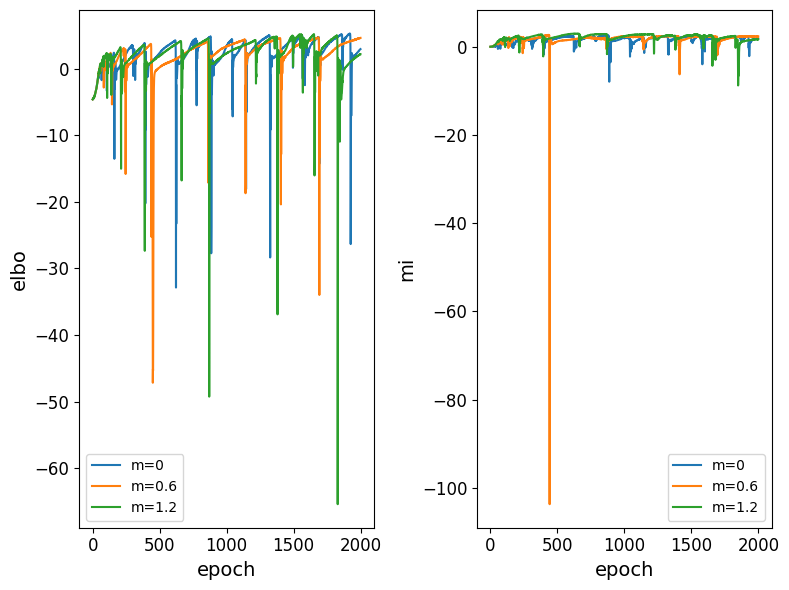

In [332]:
# plot elbo and mutual information history
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].plot(df_history1["elbo"], label="m=0")
ax[0].plot(df_history2["elbo"], label="m=0.6")
ax[0].plot(df_history3["elbo"], label="m=1.2")
#ax[0].plot(df_history4["elbo"], label="m=1.8")
#ax[0].plot(df_history5["elbo"], label="m=2.5")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("elbo")
ax[0].legend()

ax[1].plot(df_history1["mi"], label="m=0")
ax[1].plot(df_history2["mi"], label="m=0.6")
ax[1].plot(df_history3["mi"], label="m=1.2")
#ax[1].plot(df_history4["mi"], label="m=1.8")
#ax[1].plot(df_history5["mi"], label="m=2.5")
#ax[1].plot(df_history6["mi"], label="m=3.5")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("mi")
ax[1].legend()

plt.tight_layout()
plt.show()

<Axes: >

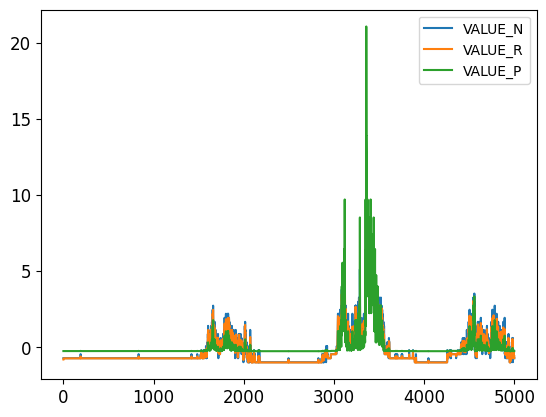

In [325]:
#df_short.plot(x='TIMESTAMP', y=['VALUE_N','VALUE_R','VALUE_P'])
df_short[['VALUE_N','VALUE_R','VALUE_P']].plot()

In [326]:
df1 = pd.DataFrame(np.clip(model1.decode(model1.encode(x).rsample()).rsample().detach().numpy(),0, None))
df2 = pd.DataFrame(np.clip(model2.decode(model2.encode(x).rsample()).rsample().detach().numpy(),0, None))
df3 = pd.DataFrame(np.clip(model3.decode(model3.encode(x).rsample()).rsample().detach().numpy(),0, None))
df4 = pd.DataFrame(np.clip(model4.decode(model4.encode(x).rsample()).rsample().detach().numpy(),0, None))
df5 = pd.DataFrame(np.clip(model5.decode(model5.encode(x).rsample()).rsample().detach().numpy(),0, None))
df6 = pd.DataFrame(np.clip(model6.decode(model6.encode(x).rsample()).rsample().detach().numpy(),0, None))

#dfs = df_short[['VALUE_N','VALUE_R']]

## Results

The vanilla VAE is not able to reconstruct the nearly 1-dimensional original data. Applying a mutual information loss penalty overcomes this hurdle.

As a consequence we can train a simple MI-VAE to properly reduce dimensions and feed the encoded data (z) into a forecaster or anomaly scorer.

<Axes: title={'center': 'VAE MI=0.6'}>

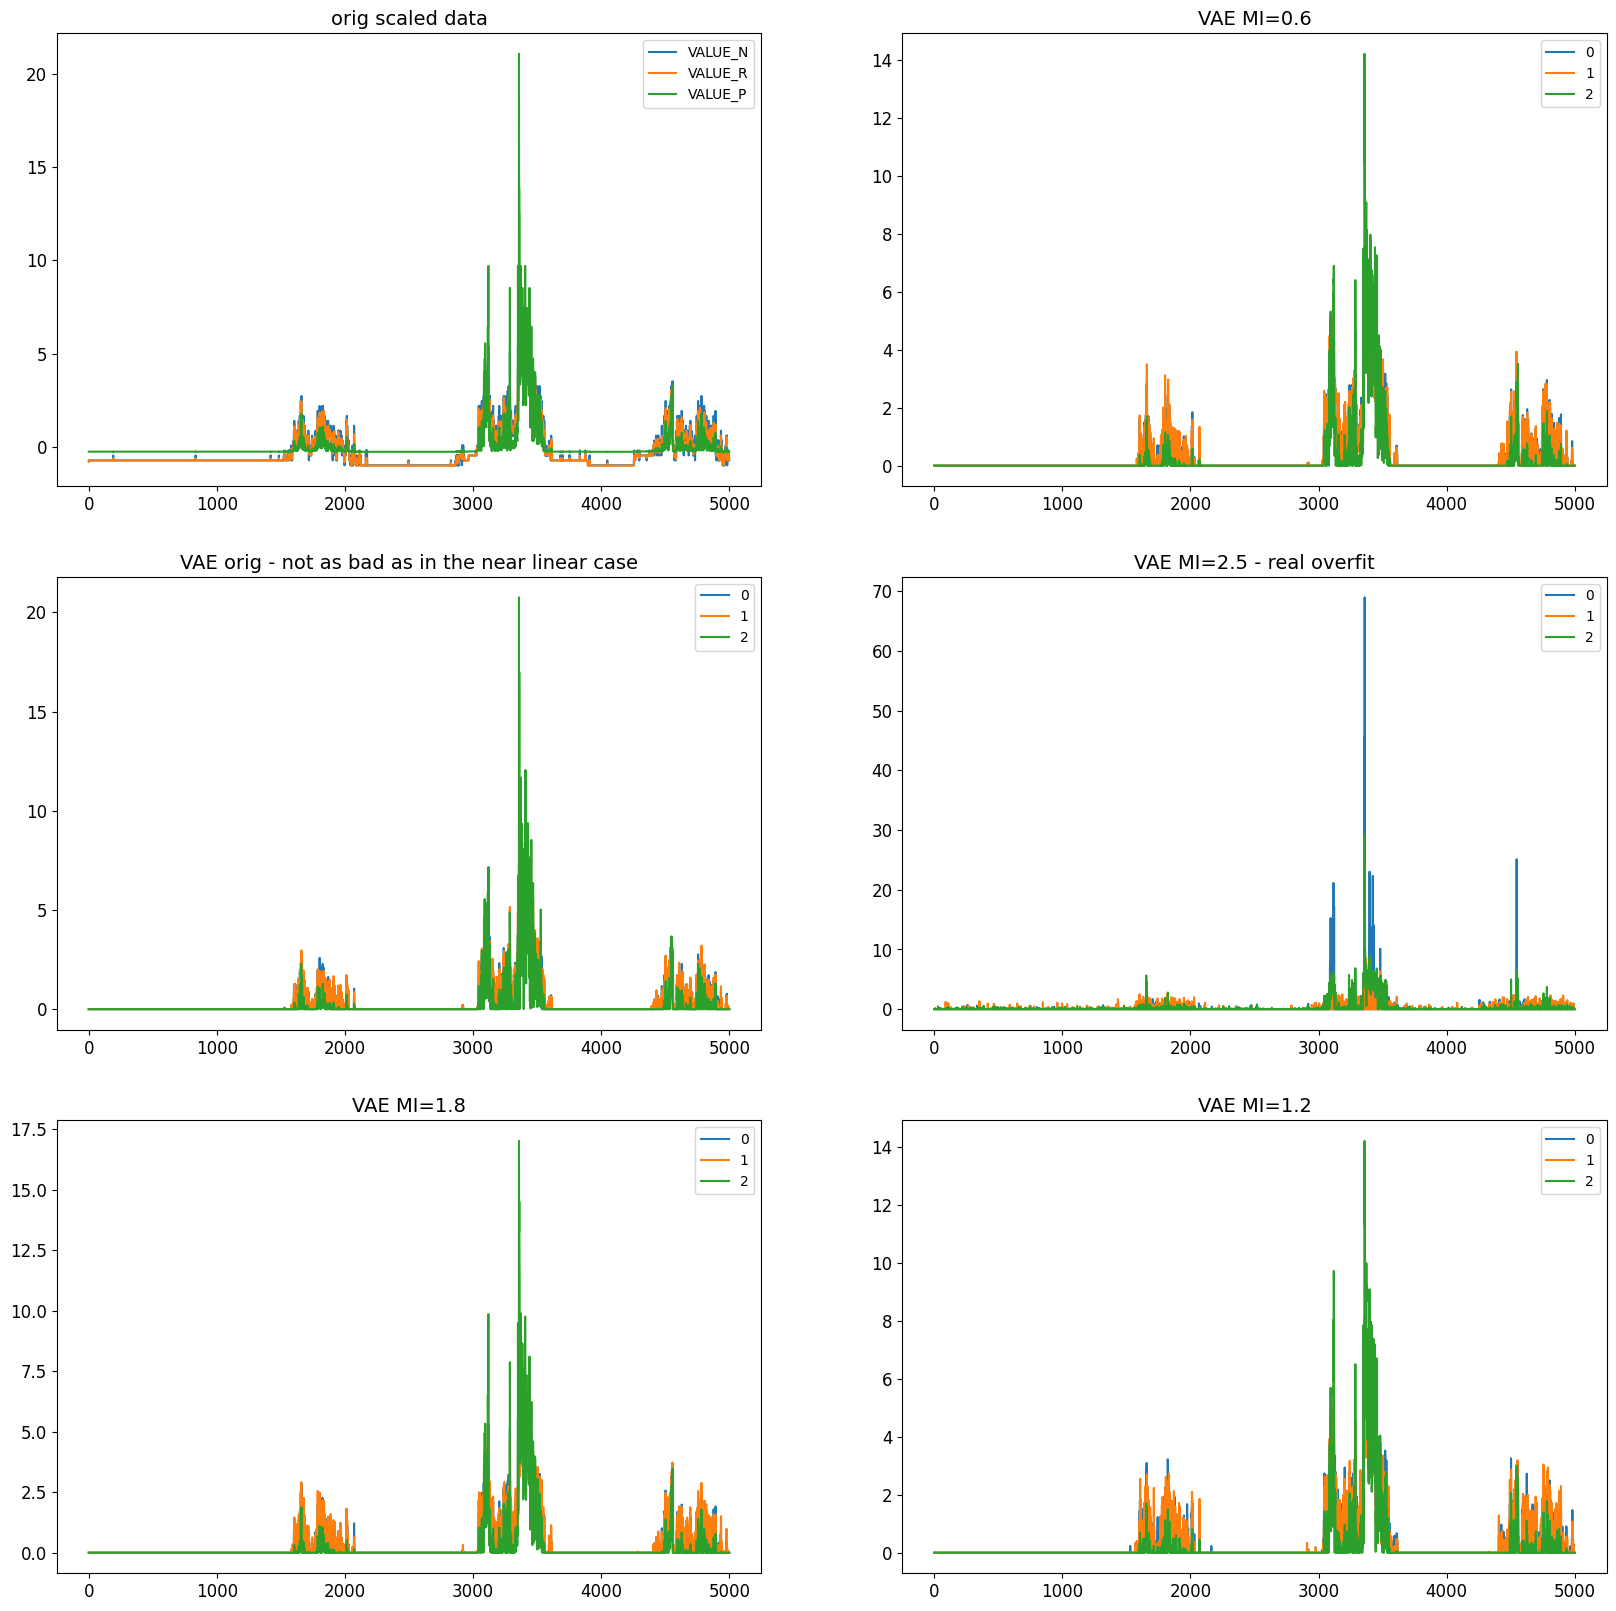

In [334]:

fig,ax = plt.subplots(3,2, figsize=(20,20))
#df_short.plot(x='TIMESTAMP', y=['VALUE_N','VALUE_R','VALUE_P'],ax=ax[0,0], xlabel='', title='orig data')
df_short[['VALUE_N','VALUE_R','VALUE_P']].plot(ax=ax[0,0], title='orig scaled data')
#df_short.plot(ax=ax[0,0], title='orig data')
#df6.plot(ax=ax[0,1], title='VAE MI=3.5 - overdone')
df1.plot(ax=ax[1,0], title='VAE orig - not as bad as in the near linear case')
df5.plot(ax=ax[1,1], title='VAE MI=2.5 - real overfit')
df4.plot(ax=ax[2,0], title='VAE MI=1.8')
df3.plot(ax=ax[2,1], title='VAE MI=1.2')
df2.plot(ax=ax[0,1], title='VAE MI=0.6')
#df1.plot(ax=ax[2,1], title='VAE orig')


In [223]:
'''
# plot splitted normals
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
plot_scaled_normals(model1, ax[0])
plot_scaled_normals(model2, ax[1])
plot_scaled_normals(model3, ax[2])
plot_scaled_normals(model4, ax[3])

ax[0].set_ylabel("mi=0")
ax[1].set_ylabel("mi=0.6")
ax[2].set_ylabel("mi=1.2")
ax[3].set_ylabel("mi=1.8")

plt.suptitle(r"$p_{\theta}(x|z)p(z)$")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
'''

'\n# plot splitted normals\nfig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)\nplot_scaled_normals(model1, ax[0])\nplot_scaled_normals(model2, ax[1])\nplot_scaled_normals(model3, ax[2])\nplot_scaled_normals(model4, ax[3])\n\nax[0].set_ylabel("mi=0")\nax[1].set_ylabel("mi=0.6")\nax[2].set_ylabel("mi=1.2")\nax[3].set_ylabel("mi=1.8")\n\nplt.suptitle(r"$p_{\theta}(x|z)p(z)$")\nplt.tight_layout(rect=[0, 0.03, 1, 0.95])\nplt.show()\n'

## Conclusion

The figure above clearly shows that we have replicated the experiment. Surprisingly, all models achieved very similar ELBO values, meaning they have fitted the data density at a more or less equal quality. However, each model contained different mutual information between the observed and the latent variables. 

While there have been a lot of discussions going on about powerful decoders completely ignoring the latent variable, my interpretation of the results here is rather that the *representation quality is an attribute of the decoder*. In the current setting, the mutual information penalty formulates a prior on the parameters of the decoder, i.e., the modeler a priori beliefs the decoding distributions should be different for different values of the latents. Only if the decoder is disentangled can we recover disentangled representations. 